### Model精神：看到開盤價買，以靠近開盤價的價格買入，然後隔日最低價賣出
* 看到今日開盤價，用昨日以前的變數，猜今天收盤是否高於今日開盤
* 如果高的話，做隔日沖，賣在明天最低點，看績效表現如何

In [46]:
import pandas as pd
import numpy as np

test_data = pd.read_csv('')

In [47]:
test_data = test_data.sort_values(['StockID','TxDate'])

In [48]:
test_data['Close_Return'] = test_data.groupby(['StockID'])['Close'].apply(
    lambda x: x / x.shift(1) - 1)

In [49]:
test_data.head(5)

,TxDate,StockID,Open,High,Low,Close,Volume,有價證券名稱,Close_Return,Open_Return,...,K_Dis_25,K_Group_30,K_Dis_30,K_Group_33,K_Dis_33,K_Group_37,K_Dis_37,K_Group_45,K_Dis_45,Pred_prob
0,2018-01-02,1101,29.490400,29.611799,29.166800,29.571301,16931822.0,台泥,NaN,0.006904,...,21.194,26,12.215,24,15.165,7,23.398,8,5.334,1.912900e-01
1,2018-01-03,1101,29.530899,30.218599,29.328600,30.218599,24670238.0,台泥,0.021889,0.001373,...,20.199,26,11.775,24,14.810,7,22.356,8,4.663,8.468853e-01
2,2018-01-04,1101,30.218599,30.299500,29.733101,30.097200,18450584.0,台泥,-0.004017,0.023287,...,17.811,26,12.526,24,15.583,7,20.015,8,5.259,7.366920e-02
3,2018-01-05,1101,30.339899,30.339899,29.975901,30.178101,43923316.0,台泥,0.002688,0.004014,...,16.885,26,13.604,24,16.590,7,19.034,8,6.544,1.590054e-08
4,2018-01-08,1101,30.259001,30.987200,30.097200,30.906300,28008482.0,台泥,0.024130,-0.002666,...,15.680,26,13.964,24,17.006,7,17.755,8,6.771,9.139091e-01


In [154]:
max(test_data['TxDate'])

'2020-10-14'

### Performance KPI
* 以投資組合來講，需要用累積報酬來衡量資產增長，記錄時間穩健成長才算

In [51]:
#收盤價累積報酬
test_data['Close_return_3sum'] = test_data.groupby(['StockID'])['Close_Return'].rolling(3).sum().reset_index(0,drop=True)

#判斷訊號發出後,3日內累積報酬

In [52]:
#判斷訊號發出後,3日內平均報酬
test_data['Close_return_3avg'] = test_data.groupby(['StockID'])['Close_Return'].rolling(3).mean().reset_index(0,drop=True)

In [53]:
test_data[['TxDate', '有價證券名稱','Close_Return','Close_return_3sum','Close_return_3avg','Pred_prob' ]].head(10)

,TxDate,有價證券名稱,Close_Return,Close_return_3sum,Close_return_3avg,Pred_prob
0,2018-01-02,台泥,NaN,NaN,NaN,1.912900e-01
1,2018-01-03,台泥,0.021889,NaN,NaN,8.468853e-01
2,2018-01-04,台泥,-0.004017,NaN,NaN,7.366920e-02
3,2018-01-05,台泥,0.002688,0.020560,0.006853,1.590054e-08
4,2018-01-08,台泥,0.024130,0.022801,0.007600,9.139091e-01
5,2018-01-09,台泥,0.002618,0.029436,0.009812,4.009083e-01
6,2018-01-10,台泥,0.003915,0.030662,0.010221,4.288410e-01
7,2018-01-11,台泥,-0.024707,-0.018175,-0.006058,1.109711e-02
8,2018-01-12,台泥,0.002666,-0.018126,-0.006042,2.824402e-01
9,2018-01-15,台泥,0.006650,-0.015391,-0.005130,3.707136e-01


In [84]:
lookup_col = ['TxDate', 'StockID','有價證券名稱','Open_pre','Close_pre',\
              'Open', 'High', 'Low', 'Close',\
              'Close_Return','Close_return_3sum','Close_return_3avg','Pred_prob']

In [85]:
test_data_pf = test_data[lookup_col].dropna(axis=0)

### Distribution of Pred Prob

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Pred_prob', ylabel='Density'>

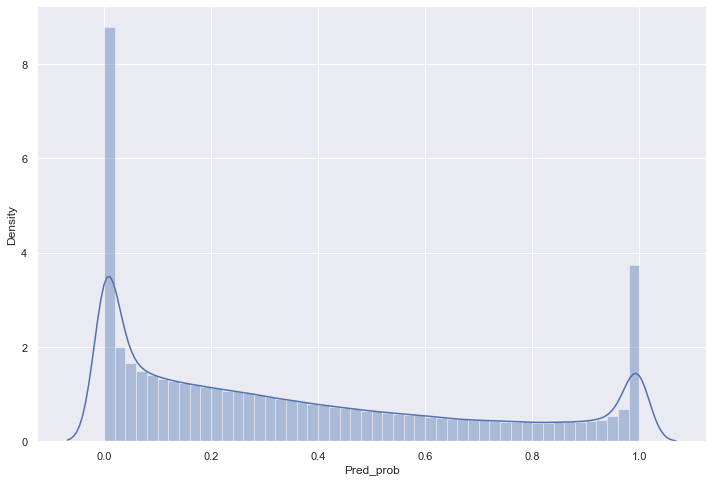

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.distplot(test_data_pf['Pred_prob'])

分三群看預測上漲機率大於0.85的，作為一個Group

In [87]:
#Group
test_data_pf['if_pos']=np.where(test_data_pf['Pred_prob']>0.85,1,0)
test_data_pf['if_med']= np.where((0.45<test_data_pf['Pred_prob'])&(test_data_pf['Pred_prob']<0.55),1,0)
test_data_pf['if_neg']=np.where(test_data_pf['Pred_prob']<0.15,1,0)

### 製作賣出訊號

In [58]:
##Create Group
test_data['pos_3'] = test_data.groupby(['StockID'])['if_pos'].shift(3)
test_data['med_3'] = test_data.groupby(['StockID'])['if_med'].shift(3)
test_data['neg_3'] = test_data.groupby(['StockID'])['if_neg'].shift(3)

In [114]:
test_neg_gp = test_data[test_data['neg_3']==1].reset_index(drop=True)
test_med_gp = test_data[test_data['med_3']==1].reset_index(drop=True)
test_pos_gp = test_data[test_data['pos_3']==1].reset_index(drop=True)

In [116]:
L = test_pos_gp[lookup_col]

In [117]:
L.columns

Index(['TxDate', 'StockID', '有價證券名稱', 'Open_pre', 'Close_pre', 'Open', 'High',
       'Low', 'Close', 'Close_Return', 'Close_return_3sum',
       'Close_return_3avg', 'Pred_prob'],
      dtype='object')

### Difference of Yearly Return between 3 Groups

In [118]:
sum(test_data[test_data['pos_3']==1]['Close_return_3sum'])\
/len(test_data[test_data['pos_3']==1]['Close_return_3sum'])*250

0.37980576980810904

In [119]:
sum(test_data[test_data['med_3']==1]['Close_return_3sum'])\
/len(test_data[test_data['med_3']==1]['Close_return_3sum'])*250

0.2712386030334628

In [120]:
sum(test_data[test_data['neg_3']==1]['Close_return_3sum'])\
/len(test_data[test_data['neg_3']==1]['Close_return_3sum'])*250

0.03072286614209577

# Strategy : 隔日沖 
買在開盤,賣在隔日低點

In [129]:
##Create Group
test_data_pf['pos_1'] = test_data_pf.groupby(['StockID'])['if_pos'].shift(1)
test_data_pf['med_1'] = test_data_pf.groupby(['StockID'])['if_med'].shift(1)
test_data_pf['neg_1'] = test_data_pf.groupby(['StockID'])['if_neg'].shift(1)

In [130]:
test_data_pf.columns

Index(['TxDate', 'StockID', '有價證券名稱', 'Open_pre', 'Close_pre', 'Open', 'High',
       'Low', 'Close', 'Close_Return', 'Close_return_3sum',
       'Close_return_3avg', 'Pred_prob', 'if_pos', 'if_med', 'if_neg', 'pos_1',
       'med_1', 'neg_1', 'S2_Return'],
      dtype='object')

In [131]:
#今日高-昨日開(訊號出) 
#test_data['S2_Return'] = (test_data['High']+test_data['Low'] )/ (2*test_data['Open_pre']) - 1
test_data_pf['S2_Return'] = test_data_pf['Low']/ test_data_pf['Open_pre'] - 1

### 示範 台股股災 2020/3/2~2020/4
* S2_Return：買開盤，隔天最低賣掉
* Case 1: 多
    1. 2020-03-02出訊號(if_pos==1),買入,下一個交易日賣掉(2020-03-02 pos_1)
    * 大概獲利 0.026570

* Case 2: 空
    1. 2020-03-18出訊號(if_neg==1),買入,下一個交易日賣掉(2020-03-19 neg_1)
    2. 2020-03-19出訊號(if_neg==1),買入,下一個交易日賣掉(2018-03-20 neg_1)
    *  兩次大概獲利 -0.105900+ (-0.021491)

In [142]:
#因為grouping去做feature, 所以兩個column直接做就好了
test_data_pf[['TxDate', 'StockID', '有價證券名稱','Open_pre', 'Open', 'High','Low','Close',\
              'S2_Return','if_neg', 'if_med', 'if_pos','pos_1', 'med_1',  'neg_1']][517:547]

,TxDate,StockID,有價證券名稱,Open_pre,Open,High,Low,Close,S2_Return,if_neg,if_med,if_pos,pos_1,med_1,neg_1
520,2020-03-02,1101,台泥,40.189899,39.428001,40.570801,39.428001,40.237499,-0.018957,0,0,1,0.0,0.0,0.0
521,2020-03-03,1101,台泥,39.428001,40.570801,40.856499,40.475601,40.618401,0.026570,0,0,0,1.0,0.0,0.0
522,2020-03-04,1101,台泥,40.570801,40.570801,40.904099,40.570801,40.808899,0.000000,0,0,0,0.0,0.0,0.0
523,2020-03-05,1101,台泥,40.570801,40.856499,41.237499,40.808899,41.237499,0.005869,0,0,0,0.0,0.0,0.0
524,2020-03-06,1101,台泥,40.856499,41.142200,41.142200,40.475601,40.808899,-0.009323,0,0,0,0.0,0.0,0.0
525,2020-03-09,1101,台泥,41.142200,40.189899,40.380299,39.713699,39.856499,-0.034721,1,0,0,0.0,0.0,0.0
526,2020-03-10,1101,台泥,40.189899,39.237499,39.904202,39.237499,39.618401,-0.023697,0,1,0,0.0,0.0,1.0
527,2020-03-11,1101,台泥,39.237499,39.999401,40.237499,39.713699,39.808899,0.012136,1,0,0,0.0,1.0,0.0
528,2020-03-12,1101,台泥,39.999401,39.713699,39.808899,38.475601,38.808899,-0.038096,1,0,0,0.0,0.0,1.0
529,2020-03-13,1101,台泥,39.713699,37.142300,38.618500,36.475601,38.332699,-0.081536,0,0,1,0.0,0.0,1.0


In [143]:
test_neg_gp = test_data_pf[test_data_pf['neg_1']==1].reset_index(drop=True)
test_med_gp = test_data_pf[test_data_pf['med_1']==1].reset_index(drop=True)
test_pos_gp = test_data_pf[test_data_pf['pos_1']==1].reset_index(drop=True)

In [144]:
test_neg_gp['Tx_Month'] = test_neg_gp['TxDate'][0:7]
test_med_gp['Tx_Month'] = test_med_gp['TxDate'][0:7]
test_pos_gp['Tx_Month'] = test_pos_gp['TxDate'][0:7]

## Visulization

In [145]:
#Join Base
t_plt = test_data[['TxDate','有價證券名稱']]

In [146]:
#月化指標
t_plt['TxDate_key'] = [datekey[0:7] for datekey in t_plt['TxDate'] ]

<ipython-input-146-d0fe75a58a6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_plt['TxDate_key'] = [datekey[0:7] for datekey in t_plt['TxDate'] ]


In [147]:
#neg
t_plt_neg = t_plt.merge(test_neg_gp[['TxDate','有價證券名稱','S2_Return']],on =['TxDate','有價證券名稱'] ,how='left')
t_plt_neg['S2_Return'] = t_plt_neg['S2_Return'].fillna(0)

#med
t_plt_med = t_plt.merge(test_med_gp[['TxDate','有價證券名稱','S2_Return']],on =['TxDate','有價證券名稱'] ,how='left')
t_plt_med['S2_Return'] = t_plt_med['S2_Return'].fillna(0)

#pos
t_plt_pos = t_plt.merge(test_pos_gp[['TxDate','有價證券名稱','S2_Return']],on =['TxDate','有價證券名稱'] ,how='left')
t_plt_pos['S2_Return'] = t_plt_pos['S2_Return'].fillna(0)


### 隔日沖年化報酬率

In [148]:
sum(t_plt_pos['S2_Return'])/len(t_plt_pos['S2_Return']) *250

0.33392540763635775

In [150]:
sum(t_plt_med['S2_Return'])/len(t_plt_med['S2_Return']) *250

-0.12741662519743024

In [149]:
sum(t_plt_neg['S2_Return'])/len(t_plt_neg['S2_Return']) *250

-2.046887767652927

#### sum return (Monthly)

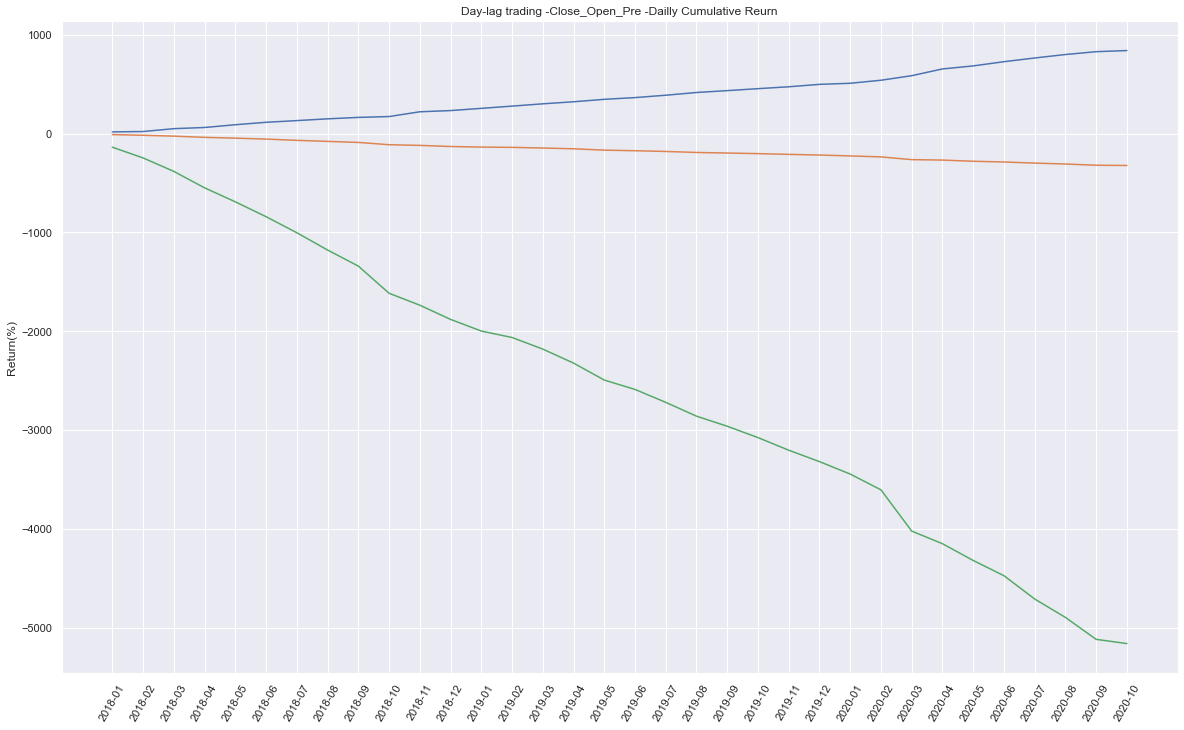

In [153]:
#sum return (Daily)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,12))
plt.plot(t_plt_pos.groupby(['TxDate_key'])['S2_Return'].sum().index,
         t_plt_pos.groupby(['TxDate_key'])['S2_Return'].sum().values.cumsum(),'-',label = 'test_pos_gp')

plt.plot(t_plt_med.groupby(['TxDate_key'])['S2_Return'].sum().index,
         t_plt_med.groupby(['TxDate_key'])['S2_Return'].sum().values.cumsum(),'-',label = 'test_pos_gp')

plt.plot(t_plt_neg.groupby(['TxDate_key'])['S2_Return'].sum().index,
         t_plt_neg.groupby(['TxDate_key'])['S2_Return'].sum().values.cumsum(),'-',label = 'test_pos_gp')

plt.grid(True)
plt.ylabel('Return(%)')
plt.xticks(rotation=60)
plt.title('Day-lag trading -Close_Open_Pre -Dailly Cumulative Reurn')

plt.show()

#### sum return (Daily)

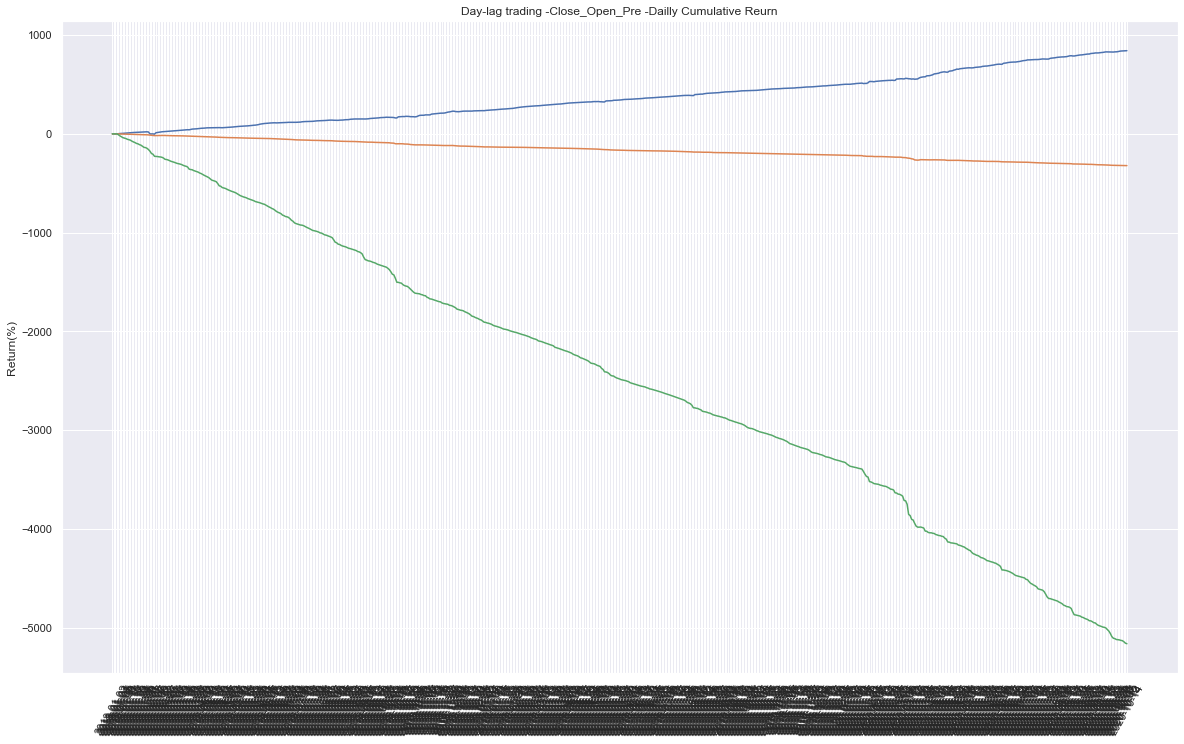

In [152]:
#sum return (Daily)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,12))
plt.plot(t_plt_pos.groupby(['TxDate'])['S2_Return'].sum().index,
         t_plt_pos.groupby(['TxDate'])['S2_Return'].sum().values.cumsum(),'-',label = 'test_pos_gp')

plt.plot(t_plt_med.groupby(['TxDate'])['S2_Return'].sum().index,
         t_plt_med.groupby(['TxDate'])['S2_Return'].sum().values.cumsum(),'-',label = 'test_pos_gp')

plt.plot(t_plt_neg.groupby(['TxDate'])['S2_Return'].sum().index,
         t_plt_neg.groupby(['TxDate'])['S2_Return'].sum().values.cumsum(),'-',label = 'test_pos_gp')

plt.grid(True)
plt.ylabel('Return(%)')
plt.xticks(rotation=60)
plt.title('Day-lag trading -Close_Open_Pre -Dailly Cumulative Reurn')

plt.show()